In [1]:
import itertools
import pathlib
import pyam # version: 1.4.1.dev15+g3563b43

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')

<IPython.core.display.Javascript object>

In [2]:
# utils.py
def make_gap_data(df, v):
    x = (
        df
        .filter(variable=v, year=[2030])
        .filter(Category=categories_to_temp.keys())
        .as_pandas()
        .replace({'Category': categories_to_temp})
    )
    idx = ['model', 'scenario', 'region', 'year', 'Category']
    x = x.set_index(idx)['value'] 
    return x

def make_gap_plot(data, drop={}, ax=None):
    data = data.reset_index().dropna()
    for col, value in drop.items():
        data = data[data[col] != value]
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 5))
    ax.axhline(0, c='k', ls='--', alpha=0.5)
    sns.boxplot(
        x="region", y="value", hue="Category",
        data=data, 
        palette="Set2_r", ax=ax, showfliers=False, whis=0,
    )
    return ax

# Load Data

In [3]:
data_path = pathlib.Path('../data')

In [4]:
LABEL = '2015_soft_grassi'

In [5]:
pddata = pd.read_csv(data_path / f'analysis_{LABEL}_data.csv')

In [6]:
df = pyam.IamDataFrame(pddata)
df.load_meta(data_path / f'analysis_{LABEL}_meta.csv')

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading meta indicators


In [7]:
categories_to_temp = {'C1': '1.5C', 'C3': '2C'}
df.meta['Temperature'] = df.meta['Category'].replace(categories_to_temp)

# Figure 2A

In [47]:
variables = [
    'Emissions|Kyoto Gases - Reanalyzed and Adjusted',
]
quantiles = (0.1, 0.25, 0.5, 0.75, 0.9)
year_start, year_end = 2010, 2100

data = pyam.concat([
    (
        df
        .filter(region='World', variable=variable, year=range(year_start, year_end + 1))
        .filter(Category=category)
        .convert_unit('Mt CO2-equiv/yr', to='Gt CO2-equiv/yr', factor=1e-3)
        .quantiles(quantiles)
        .rename(model={'unweighted': temp})
    ) for (category, temp), variable in itertools.product(categories_to_temp.items(), variables)
])

for variable in variables:
    data.append(
        df
        .filter(region='World', variable=variable, year=range(year_start, year_end + 1))
        .filter(Policy_category_name='P1b: Current policies')
        .convert_unit('Mt CO2-equiv/yr', to='Gt CO2-equiv/yr', factor=1e-3)
        .quantiles(quantiles)
        .rename(model={'unweighted': 'Current Policies'}),
        inplace=True
    )
data.append(
        df
        .filter(region='World', variable='Emissions|Kyoto Gases', year=range(year_start, year_end + 1))
        .filter(Policy_category_name='P1b: Current policies')
        .convert_unit('Mt CO2-equiv/yr', to='Gt CO2-equiv/yr', factor=1e-3)
        .quantiles(quantiles)
        .rename(model={'unweighted': 'Current Policies'}),
        inplace=True
    )
data.append(
        df
        .filter(region='World', variable='Emissions|Kyoto Gases - Reanalyzed', year=range(year_start, year_end + 1))
        .filter(Policy_category_name='P1b: Current policies')
        .convert_unit('Mt CO2-equiv/yr', to='Gt CO2-equiv/yr', factor=1e-3)
        .quantiles(quantiles)
        .rename(model={'unweighted': 'Current Policies'}),
        inplace=True
    )

In [48]:
targets = pd.DataFrame([
    ('Current Policies (den Elzen 2022, adj.)', 56.826, 52.592, 59.552, 'dimgrey', 0),
    ('Conditional NDCs (den Elzen 2022, adj.)', 50.700, 48.542, 52.202, 'plum', -0.35),
    ('Unconditional NDCs (den Elzen 2022, adj.)', 52.284, 50.059, 54.136, 'thistle', 0.35),
], columns=['label', 'med', 'min', 'max', 'color', 'jitter'])

target_2015_value = 51.181
this_study_2015_value = (
    data
    .filter(variable='Emissions|Kyoto Gases - Reanalyzed and Adjusted', year=2015, scenario='quantile_0.5')
    .timeseries()
    .mean()
    .iloc[0]
)
target_offset = target_2015_value - this_study_2015_value
target_2015_value, this_study_2015_value, target_offset
target_offset = 0

Text(0.5, 0, '')

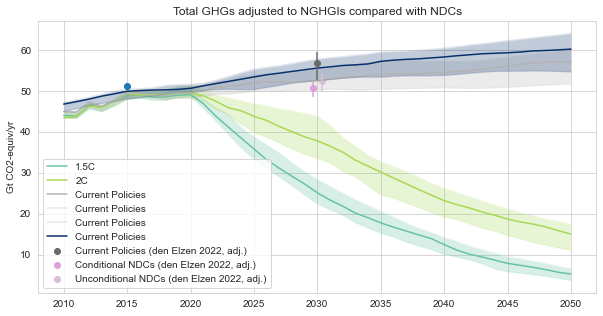

In [60]:
target_offset = 0

fig, ax = plt.subplots(figsize=(10, 5))
(
    data
    .filter(variable='Emissions|Kyoto Gases - Reanalyzed and Adjusted', year=range(1990, 2051))
    .filter(scenario=['*0.25*', '*0.75*'])
    .plot
    .line(color='model', fill_between=True, ax=ax, cmap='Set2', alpha=0.1)
)
(
    data
    .filter(variable='Emissions|Kyoto Gases - Reanalyzed and Adjusted', year=range(1990, 2051))
    .filter(scenario='quantile_0.5')
    .plot
    .line(color='model', ax=ax, cmap='Set2')
)
(
    data
    .filter(variable='Emissions|Kyoto Gases', year=range(1990, 2051))
    .filter(scenario=['*0.25*', '*0.75*'])
    .subtract(a='Emissions|Kyoto Gases', b=3.7, name='offset kyoto gases', ignore_units='Gt CO2-equiv/yr')
    .plot
    .line(color='model', fill_between=True, ax=ax, cmap='Blues_r', alpha=0.1)
)
(
    data
    .filter(variable='Emissions|Kyoto Gases', year=range(1990, 2051))
    .filter(scenario='quantile_0.5')
    .subtract(a='Emissions|Kyoto Gases', b=3.7, name='offset kyoto gases', ignore_units='Gt CO2-equiv/yr')
    .plot
    .line(color='model', ax=ax, cmap='Blues_r')
)
for i, row in targets.iterrows():
    ax.scatter(2030 + row['jitter'], row['med'] - target_offset, label=row['label'], c=row['color'])
    ax.errorbar(2030 + row['jitter'], row['med'] - target_offset, 
                yerr=np.array([[row['med'] - row['min'], row['max'] - row['med']],]).reshape(2, 1), 
                color=row['color'])
ax.scatter(2015, target_2015_value - target_offset)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[6:], labels[6:])
ax.set_title('Total GHGs adjusted to NGHGIs compared with NDCs')
ax.set_xlabel('')

Text(0.5, 0, '')

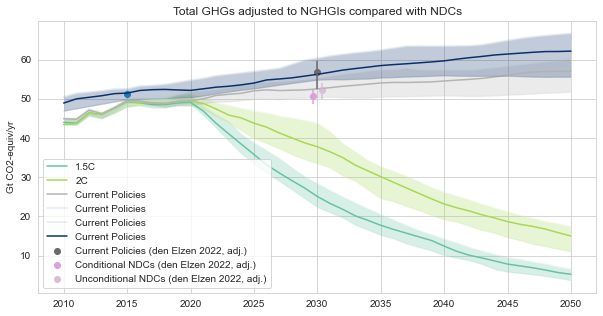

In [59]:
target_offset = 0

fig, ax = plt.subplots(figsize=(10, 5))
(
    data
    .filter(variable='Emissions|Kyoto Gases - Reanalyzed and Adjusted', year=range(1990, 2051))
    .filter(scenario=['*0.25*', '*0.75*'])
    .plot
    .line(color='model', fill_between=True, ax=ax, cmap='Set2', alpha=0.1)
)
(
    data
    .filter(variable='Emissions|Kyoto Gases - Reanalyzed and Adjusted', year=range(1990, 2051))
    .filter(scenario='quantile_0.5')
    .plot
    .line(color='model', ax=ax, cmap='Set2')
)
(
    data
    .filter(variable='Emissions|Kyoto Gases - Reanalyzed', year=range(1990, 2051))
    .filter(scenario=['*0.25*', '*0.75*'])
    .plot
    .line(color='model', fill_between=True, ax=ax, cmap='Blues_r', alpha=0.1)
)
(
    data
    .filter(variable='Emissions|Kyoto Gases - Reanalyzed', year=range(1990, 2051))
    .filter(scenario='quantile_0.5')
    .plot
    .line(color='model', ax=ax, cmap='Blues_r')
)
for i, row in targets.iterrows():
    ax.scatter(2030 + row['jitter'], row['med'] - target_offset, label=row['label'], c=row['color'])
    ax.errorbar(2030 + row['jitter'], row['med'] - target_offset, 
                yerr=np.array([[row['med'] - row['min'], row['max'] - row['med']],]).reshape(2, 1), 
                color=row['color'])
ax.scatter(2015, target_2015_value - target_offset)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[6:], labels[6:])
ax.set_title('Total GHGs adjusted to NGHGIs compared with NDCs')
ax.set_xlabel('')

Text(0.5, 0, '')

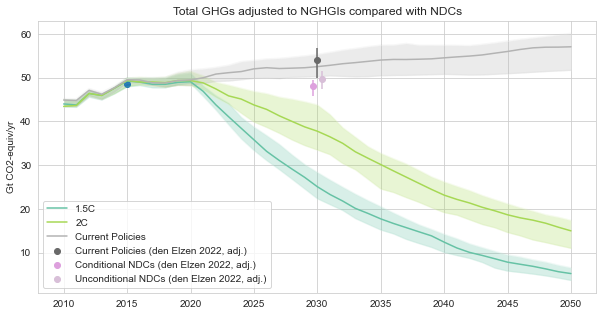

In [61]:
# this comparison is to align Den Elzen et al. with NGHGIDB (historical emissions used were FAOSTAT)

target_offset = 2.7

variable = 'Emissions|Kyoto Gases - Reanalyzed and Adjusted'
fig, ax = plt.subplots(figsize=(10, 5))
(
    data
    .filter(variable=variable, year=range(1990, 2051))
    .filter(scenario=['*0.25*', '*0.75*'])
    .plot
    .line(color='model', fill_between=True, ax=ax, cmap='Set2', alpha=0.1)
)
(
    data
    .filter(variable=variable, year=range(1990, 2051))
    .filter(scenario='quantile_0.5')
    .plot
    .line(color='model', ax=ax, cmap='Set2')
)
for i, row in targets.iterrows():
    ax.scatter(2030 + row['jitter'], row['med'] - target_offset, label=row['label'], c=row['color'])
    ax.errorbar(2030 + row['jitter'], row['med'] - target_offset, 
                yerr=np.array([[row['med'] - row['min'], row['max'] - row['med']],]).reshape(2, 1), 
                color=row['color'])
handles, labels = ax.get_legend_handles_labels()
ax.scatter(2015, target_2015_value - target_offset)
ax.legend(handles[6:], labels[6:])
ax.set_title('Total GHGs adjusted to NGHGIs compared with NDCs')
ax.set_xlabel('')

Text(0.5, 0, '')

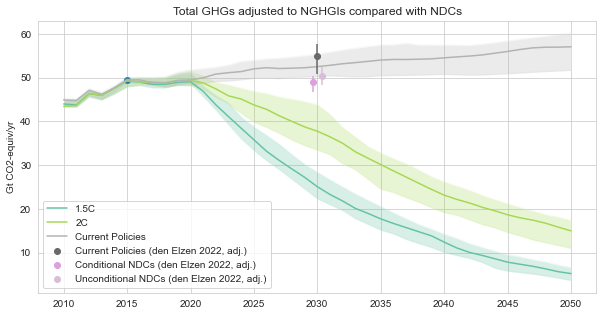

In [62]:
# this comparison is to align Den Elzen et al. with NGHGIDB (historical emissions used were FAOSTAT)

target_offset = 1.8

variable = 'Emissions|Kyoto Gases - Reanalyzed and Adjusted'
fig, ax = plt.subplots(figsize=(10, 5))
(
    data
    .filter(variable=variable, year=range(1990, 2051))
    .filter(scenario=['*0.25*', '*0.75*'])
    .plot
    .line(color='model', fill_between=True, ax=ax, cmap='Set2', alpha=0.1)
)
(
    data
    .filter(variable=variable, year=range(1990, 2051))
    .filter(scenario='quantile_0.5')
    .plot
    .line(color='model', ax=ax, cmap='Set2')
)
for i, row in targets.iterrows():
    ax.scatter(2030 + row['jitter'], row['med'] - target_offset, label=row['label'], c=row['color'])
    ax.errorbar(2030 + row['jitter'], row['med'] - target_offset, 
                yerr=np.array([[row['med'] - row['min'], row['max'] - row['med']],]).reshape(2, 1), 
                color=row['color'])
handles, labels = ax.get_legend_handles_labels()
ax.scatter(2015, target_2015_value - target_offset)
ax.legend(handles[6:], labels[6:])
ax.set_title('Total GHGs adjusted to NGHGIs compared with NDCs')
ax.set_xlabel('')

Text(0.5, 0, '')

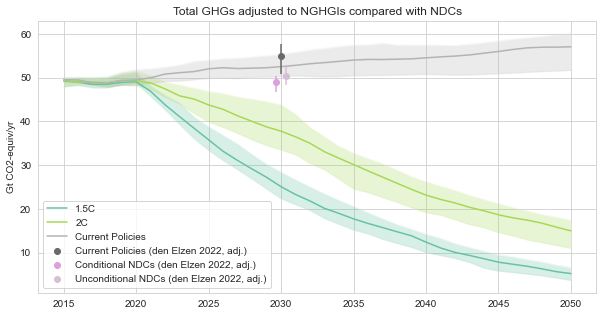

In [70]:
target_offset = target_2015_value - this_study_2015_value

variable = 'Emissions|Kyoto Gases - Reanalyzed and Adjusted'
fig, ax = plt.subplots(figsize=(10, 5))
(
    data
    .filter(variable=variable, year=range(2015, 2051))
    .filter(scenario=['*0.25*', '*0.75*'])
    .plot
    .line(color='model', fill_between=True, ax=ax, cmap='Set2', alpha=0.1)
)
(
    data
    .filter(variable=variable, year=range(2015, 2051))
    .filter(scenario='quantile_0.5')
    .plot
    .line(color='model', ax=ax, cmap='Set2')
)
for i, row in targets.iterrows():
    ax.scatter(2030 + row['jitter'], row['med'] - target_offset, label=row['label'], c=row['color'])
    ax.errorbar(2030 + row['jitter'], row['med'] - target_offset, 
                yerr=np.array([[row['med'] - row['min'], row['max'] - row['med']],]).reshape(2, 1), 
                color=row['color'])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[6:], labels[6:])
ax.set_title('Total GHGs adjusted to NGHGIs compared with NDCs')
ax.set_xlabel('')

## Gap quantification

In [89]:
med_target = targets.set_index('label')['med'] - target_offset
med_target

label
Current Policies (den Elzen 2022, adj.)      55.023575
Conditional NDCs (den Elzen 2022, adj.)      48.897575
Unconditional NDCs (den Elzen 2022, adj.)    50.481575
Name: med, dtype: float64

In [90]:
variable = 'Emissions|Kyoto Gases - Reanalyzed and Adjusted'
pathways = (
    data
    .filter(variable=variable, year=2030, scenario=['*0.5*'])
    .timeseries()
    [2030]
    .unstack('model')
    .reset_index(drop=True)
)
pathways

model,1.5C,2C,Current Policies
0,25.087212,37.771626,52.518611


In [91]:
gap = pd.DataFrame({c: med_target - float(pathways[c]) for c in pathways})
gap

,1.5C,2C,Current Policies
label,,,
"Current Policies (den Elzen 2022, adj.)",29.936362,17.251949,2.504964
"Conditional NDCs (den Elzen 2022, adj.)",23.810362,11.125949,-3.621036
"Unconditional NDCs (den Elzen 2022, adj.)",25.394362,12.709949,-2.037036


In [92]:
(12.7 - 10.8) / 10.8 # 2C

0.1759259259259258

In [93]:
(25.4 - 27.6) / 27.6

-0.07971014492753634

# Figure 2B

In [63]:
# change in emissions in negative, gap is positive
adj = make_gap_data(df, 'Change in Emissions|Kyoto Gases - Reanalyzed and Adjusted from 2020') * -1 
orig = make_gap_data(df, 'Change in Emissions|Kyoto Gases - Reanalyzed from 2020') * -1

Text(0.5, 1.0, 'Change in 2030 regional emission reductions required to limit warming')

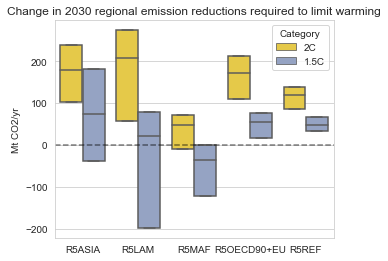

In [64]:
fig, ax = plt.subplots(figsize=(5, 4))

make_gap_plot(adj-orig, drop={'region': 'World'}, ax=ax)
ax.set_xlabel('')
ax.set_ylabel('Mt CO2/yr')


ax.set_title(f'Change in 2030 regional emission reductions required to limit warming')

## Figure for SI

Text(0.5, 1.0, 'Change in 2030 regional emission reductions required \nto limit warming relative to the reductions not aligned to NGHGIs')

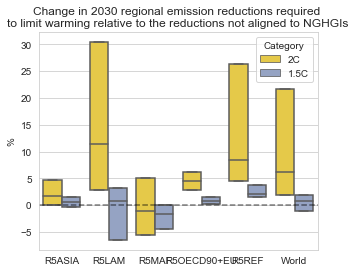

In [66]:
fig, ax = plt.subplots(figsize=(5, 4))

make_gap_plot(100 * ((adj / orig) - 1), ax=ax)
ax.set_xlabel('')
ax.set_ylabel('%')

ax.set_title(
    'Change in 2030 regional emission reductions required \n'
    'to limit warming relative to the reductions not aligned to NGHGIs'
)